In [53]:
# importing helper libraries
import numpy as np
import pandas as pd
# import machine learning libraries
import tensorflow as tf
from tensorflow import keras
# Importing data preprocessing techniques
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Data Reading, Downloaded from Yahoo Finance

In [42]:
data = pd.read_csv("../BTC-USD.csv")
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-04-23,5399.365723,5633.802246,5389.408691,5572.362305,5572.362305,1.586731e+10
1,2019-04-24,5571.508301,5642.044434,5418.263184,5464.866699,5464.866699,1.704803e+10
2,2019-04-25,5466.524414,5542.238281,5181.338867,5210.515625,5210.515625,1.533028e+10
3,2019-04-26,5210.304688,5383.634277,5177.368652,5279.348145,5279.348145,1.681211e+10
4,2019-04-27,5279.471191,5310.750000,5233.635742,5268.291016,5268.291016,1.311127e+10


In [47]:
data.isna().astype("int").sum()

Date         0
Open         1
High         1
Low          1
Close        1
Adj Close    1
Volume       1
dtype: int64

In [48]:
# we need to remove null or NaN value from our dataset
data.dropna(inplace = True)
data.isna().astype("int").sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [49]:
required_data = data[["High", "Low", "Close"]]
required_data.head()

,High,Low,Close
0,5633.802246,5389.408691,5572.362305
1,5642.044434,5418.263184,5464.866699
2,5542.238281,5181.338867,5210.515625
3,5383.634277,5177.368652,5279.348145
4,5310.750000,5233.635742,5268.291016


# Data Preprocessing

In [133]:
train_data_length = int(0.9 * len(required_data))

In [134]:
# Before we normalize the data, we need to split the data into train and test split, so that data snooping can be
# avoided

train_data = required_data.iloc[:train_data_length]
test_data = required_data.iloc[train_data_length:]

print(f"Training data : {train_data.shape}")
print(f"Testing data : {test_data.shape}")

Training data : (1645, 3)
Testing data : (183, 3)


In [135]:
# Data Normalization
# This will scale the data between -1 and 1
normalizer = MinMaxScaler(feature_range = (-1, 1))
# Fit the normalizer on the train data only
normalizer.fit(train_data)


# converting the train data
train_data = normalizer.transform(train_data)
test_data  = normalizer.transform(test_data)

print(f"Training data : {train_data.shape}")
print(f"Testing data : {test_data.shape}")

Training data : (1645, 3)
Testing data : (183, 3)


In [136]:
# checking the range of train data and test data
print(f"Maximum and minimum value of training data : {np.max(train_data), np.min(train_data)}")
print(f"Maximum and minimum value of testing  data : {np.max(test_data), np.min(test_data)}")

Maximum and minimum value of training data : (1.0, -0.9999999999999999)
Maximum and minimum value of testing  data : (1.1762626476551192, -0.0885956646837236)


In [138]:
# this piece of code creates the data where features and targets are multivariate

def create_window_split_with_target_multivariate(data, window_size, horizon=1, stride=1):
    """
    Function to split a multivariate time series data into overlapping windows and generate target variables.
    
    Parameters:
        data (numpy.ndarray): The input multivariate time series data with shape (num_samples, num_features).
        window_size (int): Size of each window.
        horizon (int): Forecast horizon, i.e., number of future time steps to predict. Default is 1.
        stride (int): The stride or step size between consecutive windows. Default is 1.
    
    Returns:
        numpy.ndarray, numpy.ndarray: Arrays containing the split windows and corresponding target variables.
    """
    num_samples = len(data)
    num_features = data.shape[1]
    num_windows = (num_samples - window_size - horizon) // stride + 1
    windows = np.zeros((num_windows, window_size, num_features))
    targets = np.zeros((num_windows, num_features))
    
    for i in range(num_windows):
        start_index = i * stride
        end_index = start_index + window_size
        windows[i] = data[start_index:end_index]
        targets[i] = data[end_index + horizon - 1]  # Assuming the target is the value at the end of the forecast horizon
    
    return windows, targets


window_size = 15
horizon = 1
stride = 1

train_features, train_lables = create_window_split_with_target_multivariate(train_data, window_size, horizon, stride)
test_features, test_lables = create_window_split_with_target_multivariate(test_data, window_size, horizon, stride)


print(f"Training Data : {train_features.shape, train_lables.shape}")
print(f"Testing Data : {test_features.shape, test_lables.shape}")

Training Data : ((1630, 15, 3), (1630, 3))
Testing Data : ((168, 15, 3), (168, 3))


# Model Training and Evaluation

In [139]:
from tensorflow.keras.layers import GRU

model = tf.keras.Sequential(
    [
        keras.layers.Input(shape = (15, 3)),
        keras.layers.Bidirectional(GRU(units = 128, activation = "gelu", return_sequences = True)),
        keras.layers.GroupNormalization(),
        keras.layers.Bidirectional(GRU(units = 128, activation = "gelu")),
        keras.layers.GroupNormalization(),
        keras.layers.Dense(units = 64, activation = "gelu"),
        keras.layers.Dense(units = 3, activation = "tanh")  
    ]
)
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_2 (Bidirecti  (None, 15, 256)           102144    
 onal)                                                           
                                                                 
 group_normalization_2 (Gro  (None, 15, 256)           512       
 upNormalization)                                                
                                                                 
 bidirectional_3 (Bidirecti  (None, 256)               296448    
 onal)                                                           
                                                                 
 group_normalization_3 (Gro  (None, 256)               512       
 upNormalization)                                                
                                                                 
 dense_14 (Dense)            (None, 64)              

In [140]:
model.compile(optimizer = keras.optimizers.Adam(learning_rate = 0.001), loss = "mse", metrics = ["mse"])

In [141]:
model.fit(train_features, train_lables, epochs = 1000, validation_data = (test_features, test_lables))

Epoch 1/1000
51/51 [==============================] - 9s 43ms/step - loss: 0.1753 - mse: 0.1753 - val_loss: 0.1093 - val_mse: 0.1093
Epoch 2/1000
51/51 [==============================] - 1s 28ms/step - loss: 0.0124 - mse: 0.0124 - val_loss: 0.0167 - val_mse: 0.0167
Epoch 3/1000
51/51 [==============================] - 1s 28ms/step - loss: 0.0024 - mse: 0.0024 - val_loss: 0.0145 - val_mse: 0.0145
Epoch 4/1000
51/51 [==============================] - 1s 29ms/step - loss: 0.0018 - mse: 0.0018 - val_loss: 0.0089 - val_mse: 0.0089
Epoch 5/1000
51/51 [==============================] - 1s 28ms/step - loss: 0.0020 - mse: 0.0020 - val_loss: 0.0163 - val_mse: 0.0163
Epoch 6/1000
51/51 [==============================] - 1s 28ms/step - loss: 0.0016 - mse: 0.0016 - val_loss: 0.0063 - val_mse: 0.0063
Epoch 7/1000
51/51 [==============================] - 1s 28ms/step - loss: 0.0018 - mse: 0.0018 - val_loss: 0.0069 - val_mse: 0.0069
Epoch 8/1000
51/51 [==============================] - 1s 28ms/step - 

KeyboardInterrupt: 

In [142]:
model.evaluate(test_features, test_lables)

6/6 [==============================] - 0s 10ms/step - loss: 0.0085 - mse: 0.0085


[0.008485890924930573, 0.008485890924930573]

In [143]:
test_predicts = model.predict(test_features)

6/6 [==============================] - 1s 10ms/step


In [105]:
import matplotlib.pyplot as plt


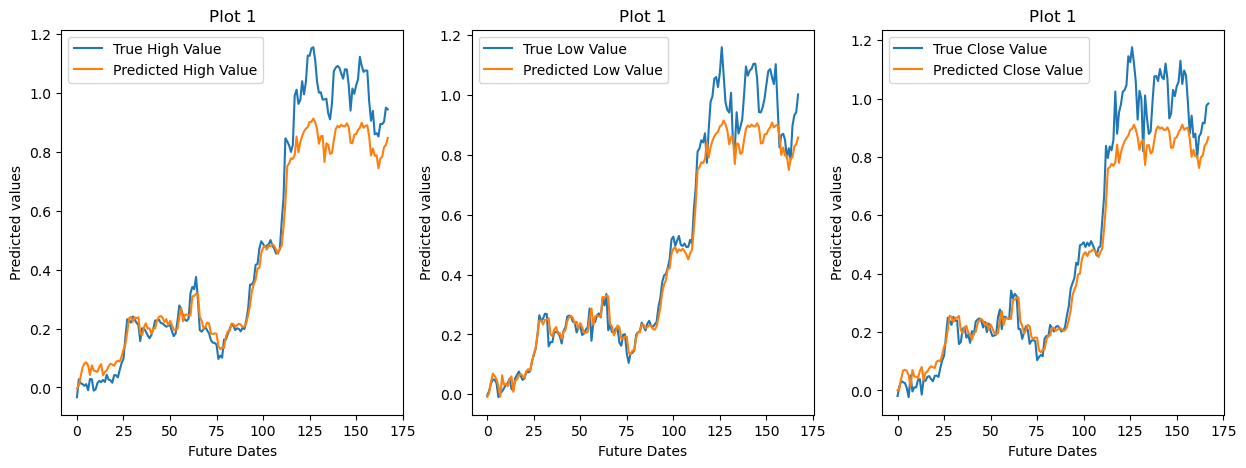

In [153]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].plot(test_lables[:, 0], label = "True High Value")
axes[0].plot(test_predicts[:, 0], label = "Predicted High Value")
axes[0].set_title('Plot 1')
axes[0].set_xlabel('Future Dates')
axes[0].set_ylabel('Predicted values')
axes[0].legend()

axes[1].plot(test_lables[:, 1], label = "True Low Value")
axes[1].plot(test_predicts[:, 1], label = "Predicted Low Value")
axes[1].set_title('Plot 1')
axes[1].set_xlabel('Future Dates')
axes[1].set_ylabel('Predicted values')
axes[1].legend()

axes[2].plot(test_lables[:, 2], label = "True Close Value")
axes[2].plot(test_predicts[:, 2], label = "Predicted Close Value")
axes[2].set_title('Plot 1')
axes[2].set_xlabel('Future Dates')
axes[2].set_ylabel('Predicted values')
axes[2].legend()
plt.show()


In [155]:
tf.keras.models.save_model(model, "../model.ckpt")

INFO:tensorflow:Assets written to: ../model.ckpt\assets


INFO:tensorflow:Assets written to: ../model.ckpt\assets


In [1]:
import tensorflow as tf

In [2]:
tf.__version__

'2.15.1'